## Summary
Compared with baseline (separate classes, specified val/test dates, 1CH, Goose 1st):
* Try combining classes (CNN_Attention_Combined.ipynb)
    * Roughly the same accuracy
    * No impact on val loss lower than train loss
* Try mixing data from different dates (CNN_Attention_Mixed_Dates.ipynb)
    * Train loss similar, val loss lower
    * Train loss lower than val loss
* Try 62 CHs (CNN_Attention_CH62.ipynb)
    * Unfinished
    * Use Gino's best CNN 62CH model
    * Modify input dimensions of last linear layer of CNN if needed
* Train on Goose and predict on Jester (CNN_Attention_Goose_Jester.ipynb)
    * Existence of peaks of val accuracies 
    * Without tuning, around 0.82 val accuracy
    * By tuning attention dimension and/or T_length, could reach 0.90 val accuracy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
import operator
import pdb
import random
from random import sample

from utils import *

### Define 
channel, width of each spectrogram in the time direction and bad dates (with artifacts), validation dates, test dates, paths

In [2]:
CH = 23
time_window = 10 # width of the spectrogram in the time direction 
T_length = 3 # how many spectrograms grouped together
proceed = 1 # Parameter controlling overlap across spectrogram. 1 = max overalp, T_length-1 = no overlap
device = torch.device("cuda")
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']

In [3]:
val_dates = ['180327','180329']
test_dates = ['180330','180331']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/'
# save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/...' 

In [4]:
sleep_files = os.listdir(load_path+'sleep/')
move_files = os.listdir(load_path+'move/')
all_files = sleep_files+move_files
f = all_files[0]
print(f)
f.split('_')[-1].split('.')[0]

180324_003_62_time1036.0_sleep.npy


'sleep'

In [5]:
print(device)
torch.cuda.empty_cache()

cuda


### Function to create the data set and make it into grouped spectrograms (windows)
The function assigns the label 1 to sleep and label 0 to movement, creates a dictionary to store the data set and groups the data into sets of spectrograms by calling the function create_files_new_helper

In [24]:
def create_files_new(load_path, bad_dates, T_length=3, proceed=1):
    
    sleep_files = os.listdir(load_path+'sleep/')
    move_files = os.listdir(load_path+'move/')
    all_files = sleep_files+move_files
    
    dic = {}
    for f in all_files:
        mvmt_type = f.split('_')[-1].split('.')[0]
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        time = float(f.split('_')[3][4:])
        if date in bad_dates:
            continue
        if mvmt_type == 'sleep':
            label = 1
        else:
            label = 0
        if date in dic:
            if rec in dic[date]:
                dic[date][rec].append([f, label, mvmt_type, date, rec, time])
            else:
                dic[date][rec] = [[f, label, mvmt_type, date, rec, time]]
        else:
            dic[date] = {rec: [[f, label, mvmt_type, date, rec, time]]}
      
    for d in dic:
        for r in dic[d]:
            dic[d][r] = sorted(dic[d][r], key=operator.itemgetter(3, 4, 5)) # sort based on date, rec, ascending time interval
            cnt += len(dic[d][r])            
            
    move_data, sleep_data = [], []
    for d in dic:
        for r in dic[d]:
            sleep_grouped, move_grouped = create_files_new_helper(dic[d][r], T_length=T_length, proceed=proceed)
            sleep_data.append(sleep_grouped)
            move_data.append(move_grouped)
    
    return move_data, sleep_data

### Function to group  a set of spectrogram windows together
T_length = number of spectrograms grouped together <br>
time_window = width of each spectrogram in the time direction <br>
proceed =  number of time overlaps across different windows. <br> Proceed = 1, max overlap. Proceed = time_window-1, no overlap

In [7]:
def create_files_new_helper(L, T_length, proceed):
    
    # for each date and for each recording in that date 
    L_labels = np.array([L[i][1] for i in range(len(L))]) # get the labels for that specific recording
    L_times = np.array([L[i][-1] for i in range(len(L))]) # get the starting time of that time window, e.g. 20 sec, 30 sec
    
    L_new_sleep, L_new_move = [], []
    start = 0
    while start <= len(L)-T_length:
        end = start + T_length
        
        if sum(L_times[start+1:end]-L_times[start:end-1]-time_window) != 0:
            start += 1
            continue
        if sum(L_labels[start:end]) == T_length:
            L_new_sleep.append(L[start:end])
        elif sum(L_labels[start:end]) == 0:
            L_new_move.append(L[start:end])
        start += proceed
#         pdb.set_trace()

    return L_new_sleep, L_new_move

### Split the data into train, validation, and test

In [25]:
move_files, sleep_files, cnt = create_files_new(load_path, bad_dates, T_length=T_length, proceed=proceed)
train_files, val_files, test_files = [], [], []

cnt_i = 0
# split data into train, validation, test
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates: #f[0][1][3] correspond to the date field
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

### Shuffle data sets 

In [26]:
# random shuffle the data across groups
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [27]:
len(train_files)*10 + len(val_files)*10 + len(test_files)*10

202440

### Upsample smaller TRAINING data set (movement) in order to have a balanced sleep/movement data set

In [11]:
def upsample(train_files):
    train_sleep = [i for i in train_files if i[0][1] == 1] # list of 1s
    train_move = [i for i in train_files if i[0][1] == 0]  # list of 0s
    diff = abs(len(train_sleep)-len(train_move))
    train_new = []
    d = 0
    while d < diff:
        if len(train_sleep) > len(train_move):
            ind = random.randint(0, len(train_move)-1)
            x = train_move[ind]
            d += 1
        else:
            ind = random.randint(0, len(train_sleep)-1)
            x = train_sleep[ind]
            d += 1
        train_new.append(x)   
    train_files = train_sleep+train_move+train_new
    return train_files

In [12]:
train_files = upsample(train_files)

### Downsample validation 

In [13]:
## Balance val 
sleep_files = []
move_files = []
for t in range(len(val_files)):
    if 'sleep' in val_files[t][0]:
        sleep_files.append(val_files[t])
    if 'move' in val_files[t][0]:
        move_files.append(val_files[t])

sleep_sample = sample(sleep_files, len(move_files))
val_2_files = sleep_sample+move_files

In [14]:
print('training data volume: ',len(train_files))
print('validation data volume: ',len(val_2_files))
print('rate val/train {:.2f}'.format(len(val_2_files)/len(train_files)))

training data volume:  17266
validation data volume:  2004
rate val/train 0.12


###  print some stuff

In [16]:
# print(train_files)
print(len(train_files)) # total number of grouped spectrograms in training set 
group = train_files[2]
f, label, mvmt_type, _, _, time = group[0]
print(group)
spec = torch.from_numpy(np.load(load_path+mvmt_type+'/'+f))
print(spec.shape)
torch.transpose(spec[:,:,:].unsqueeze(0),2,1).shape

17266
[['180324_006_62_time5953.0_sleep.npy', 1, 'sleep', '180324', '006', 5953.0], ['180324_006_62_time5963.0_sleep.npy', 1, 'sleep', '180324', '006', 5963.0], ['180324_006_62_time5973.0_sleep.npy', 1, 'sleep', '180324', '006', 5973.0]]
torch.Size([62, 10, 100])


torch.Size([1, 10, 62, 100])

### Load Data Set - Class

In [17]:
class SpectrogramDatasetAtt(Dataset):
    def __init__(self, files, load_path, T_length, all_label=False, CH=None):
        self.CH = CH
        self.files = files
        self.load_path = load_path
        self.T_length = T_length
        self.all_label = all_label
  
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        group = self.files[idx]
        specs, labels, dates, recs, times = [], [], [], [], []
        
        for i in range(len(group)): # for each window in the group 
            f, label, mvmt_type, date, rec, time = group[i]
            spec = torch.from_numpy(np.load(self.load_path+mvmt_type+'/'+f)) # load the spectrogram file
            if self.CH is not None: 
                # get spectrogram for specific channel
                spec = torch.transpose(spec[self.CH,:,:].unsqueeze(0), 2, 1) # careful with the dimensions order here 
            else:
                # get spectrograms for 62 channels 
                spec = torch.transpose(spec, 2, 1) # careful with the dimension order here 
            # append spectrograms and metadata
            specs.append(spec)
            labels.append(torch.Tensor([label]))
            dates.append(date)
            recs.append(rec)
            times.append(time)
            if i == (self.T_length-1)/2: # what happens if T_length is even?
                label_mid = torch.Tensor([label])
                date_mid = date
                rec_mid = rec
                time_mid = time
        if self.all_label:
            return specs, labels, dates, recs, times
        else:
            return specs, label_mid, date_mid, rec_mid, time_mid

### Data Loaders

In [28]:
train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=True, CH=CH)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=True, CH=CH)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=True, CH=CH)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

In [29]:
for specs, labels, dates, recs, times in train_loader:
    break
specs[0].shape

torch.Size([128, 1, 100, 10])

### Print inputs

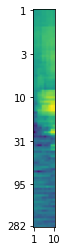

In [30]:
# check if input makes sense
plt.imshow(specs[0][0, 0, :, :])
plt.yticks(ticks=[0, 20, 40, 60, 80, 99], labels=[round(np.logspace(0, 2.45, 100)[i]) for i in [0, 20, 40, 60, 80, 99]])
plt.xticks(ticks=[0, 9], labels=[1, 10])
plt.show()

### Positional encoding

In [21]:
def position_encoding_init(n_position, emb_dim):
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / emb_dim) for j in range(emb_dim)]
        if pos != 0 else np.zeros(emb_dim) for pos in range(n_position)])
    
    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # apply sin on 0th,2nd,4th...emb_dim
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # apply cos on 1st,3rd,5th...emb_dim
    return torch.from_numpy(position_enc).type(torch.FloatTensor)

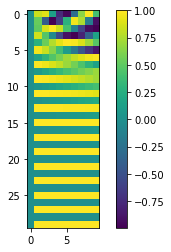

In [22]:
a = position_encoding_init(10, 30).numpy().T
plt.imshow(a)
plt.colorbar()
plt.show()

In [22]:
# class ScaledDotProductAttention(nn.Module):
#     """
#     Scaled Dot-Product Attention proposed in "Attention Is All You Need"
#     Compute the dot products of the query with all keys, divide each by sqrt(dim),
#     and apply a softmax function to obtain the weights on the values
#     Args: dim, mask
#         dim (int): dimention of attention
#         mask (torch.Tensor): tensor containing indices to be masked
#     Inputs: query, key, value, mask
#         - **query** (batch, q_len, d_model): tensor containing projection vector for decoder.
#         - **key** (batch, k_len, d_model): tensor containing projection vector for encoder.
#         - **value** (batch, v_len, d_model): tensor containing features of the encoded input sequence.
#         - **mask** (-): tensor containing indices to be masked
#     Returns: context, attn
#         - **context**: tensor containing the context vector from attention mechanism.
#         - **attn**: tensor containing the attention (alignment) from the encoder outputs.
#     """
#     def __init__(self, dim: int):
#         super(ScaledDotProductAttention, self).__init__()
#         self.sqrt_dim = np.sqrt(dim)

#     def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tuple[Tensor, Tensor]:
#         score = torch.bmm(query, key.transpose(1, 2)) / self.sqrt_dim

#         if mask is not None:
#             score.masked_fill_(mask.view(score.size()), -float('Inf'))

#         attn = F.softmax(score, -1)
#         context = torch.bmm(attn, value)
#         return context, attn

### Specify models and training parameters

In [23]:
# learning_rate = 0.001
# num_epochs = 31
# model_type = 'CNN-Attention'
# loss_type = 'bce'
# p_dropout = 0.2
# p_dropout_att = 0.2
# att_dim = 128
# T_length = 3
# all_label = True
# verbose = True

# model_CNN = CNN(p_dropout, att_dim).to(device)
# model_Att = Attention1(att_dim, T_length,p_dropout_att, all_label).to(device)


# specs, labels, dates, recs, times = next(iter(train_loader))
# labels = torch.stack(labels).transpose(1,0)
# labels = labels.to(device).float()

# torch.LongTensor([list(range(T_length))])
# CNN_outputs = torch.zeros(specs[0].shape[0], len(specs), att_dim, device=device) 

    
# for t in range(T_length):
#     data_t = specs[t].to(device).float()
#     CNN_outputs[:, t, :] = model_CNN(data_t)
#     print(CNN_outputs.shape)
# pos = torch.LongTensor([list(range(T_length))]).to(device)
# Att_outputs = model_Att(CNN_outputs, pos)
# print(Att_outputs.shape)

In [24]:
# predictions = (Att_outputs > 0.5) * 1.0
# len(predictions)
# predictions = predictions.flatten().detach().cpu().numpy()
# labels = labels.flatten().cpu().numpy()

### Accuracy function 

In [31]:
def get_accuracy(model_CNN, model_Att, loader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels, _, _, _ in loader:
            labels = torch.stack(labels).transpose(1,0)
            labels = labels.to(device).float()
            CNN_outputs = torch.zeros(data[0].shape[0], len(data), att_dim, device=device) 
            
            # for all the spectrogram in the group, stack up the CNN output
            for t in range(T_length):
                data_t = data[t].to(device).float()
                CNN_outputs[:, t, :] = model_CNN(data_t) # batch size x attention dim
            pos = torch.LongTensor([list(range(T_length))]).to(device)
            Att_outputs = model_Att(CNN_outputs, pos)
            predictions = (Att_outputs > 0.5) * 1.0
            predictions = predictions.flatten().detach().cpu().numpy()
            labels = labels.flatten().cpu().numpy()
            total += len(labels)
            correct += (predictions == labels).sum()
            
    accuracy = correct / total
    return accuracy

### Train and evaluate functions

In [32]:
def train(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, loader, T_length, device):
    model_CNN.train()
    model_Att.train()
    epoch_losses = 0
    epoch_lens = 0
    
    for batch_idx, (data, labels, _, _, _) in enumerate(loader):
        labels = torch.stack(labels).transpose(1,0)
        labels = labels.to(device).float()
        CNN_outputs = torch.zeros(data[0].shape[0], len(data), att_dim, device=device) # create tensor to store CNN outputs 
        for t in range(T_length):
            data_t = data[t].to(device).float()
            CNN_outputs[:, t, :] = model_CNN(data_t)
        pos = torch.LongTensor([list(range(T_length))]).to(device)
        Att_outputs = model_Att(CNN_outputs, pos)
        loss = criterion(Att_outputs, labels)
        epoch_losses += loss
        epoch_lens += 1

        optimizer_CNN.zero_grad()
        optimizer_Att.zero_grad()
        loss.backward() # Will back propogation work correctly?
        optimizer_CNN.step()
        optimizer_Att.step()
    
    epoch_accs = get_accuracy(model_CNN, model_Att, loader, device=device)
    return epoch_losses/epoch_lens, epoch_accs

def evaluate(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, loader, T_length, device='cuda'):
    
    model_CNN.eval()
    model_Att.eval()
    epoch_losses = 0
    epoch_lens = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, _, _, _) in enumerate(loader):
            labels = torch.stack(labels).transpose(1,0)
            labels = labels.to(device).float()
            CNN_outputs = torch.zeros(data[0].shape[0], len(data), att_dim, device=device)
            for t in range(T_length):
                data_t = data[t].to(device).float()
                CNN_outputs[:, t, :] = model_CNN(data_t)
            pos = torch.LongTensor([list(range(T_length))]).to(device)
            Att_outputs = model_Att(CNN_outputs, pos)
            loss = criterion(Att_outputs, labels)
            epoch_losses += loss
            epoch_lens += 1
    
    epoch_accs = get_accuracy(model_CNN, model_Att, loader, device=device)
    return epoch_losses/epoch_lens, epoch_accs

### CNN and Attention class

In [33]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py

class CNN(nn.Module):
    def __init__(self, p_dropout, out_dim):
        super(CNN, self).__init__()
        
        # CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p_dropout)
        self.bn1 = nn.BatchNorm2d(2)
        self.bn2 = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(4*25*2, out_dim)
              
    def forward(self, x):
        # CNN
        x = x.float()
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.shape[0],-1) 
        x = self.dropout(x) # perhaps remove dropout
        x = self.fc1(x)
        
        return x
    

class Attention1(nn.Module):
    def __init__(self, att_dim, T_length, p_dropout, all_label=False):
        super(Attention1, self).__init__()
        
        # Positional Encoding
        self.position_enc = nn.Embedding(T_length, att_dim)
        self.position_enc.weight.data = position_encoding_init(T_length, att_dim)

        # Attention
        self.query = nn.Linear(att_dim, att_dim)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=-1) # every slice along dim will sum to 1
        self.ff1 = nn.Linear(att_dim, att_dim)
        self.relu = nn.ReLU()
        self.ff2 = nn.Linear(att_dim, att_dim)
        
        self.fc = nn.Linear(att_dim, 1) # paper uses 2 layers
        
        self.dropout = nn.Dropout(p_dropout)
       
        self.T_length = T_length
        self.all_label = all_label
        
    def forward(self, x, x_pos):
        x = x.float()        
#         x += self.position_enc(x_pos)
        
        Q = self.query(x)  # Q = X*W + B
#         Q = self.dropout(Q)
        
        energy =  torch.bmm(Q, x.permute(0, 2, 1)) # Q*X_T
        attention = self.softmax(self.tanh(energy)) # alpha
#         attention = self.softmax(energy)
        x_att = torch.bmm(attention, x) # Attention 

        x_att = self.dropout(x_att)
#         x_output = torch.sigmoid(self.fc(x_att))
#         x_att = self.ff2(self.relu(self.ff1(x_att)))
#         x_att = self.dropout(x_att)
        x_output = torch.sigmoid(self.fc(x_att))
      
        if self.all_label:
            return x_output
        return x_output[:, int((self.T_length-1)/2), :]


### Specify models and training parameters

In [33]:
learning_rate = 0.001
num_epochs = 31
model_type = 'CNN-Attention'
loss_type = 'bce'
p_dropout = 0.2
p_dropout_att = 0.2
att_dim = 128
T_length = 3
all_label = True
verbose = True

model_CNN = CNN(p_dropout, att_dim).to(device)
model_Att = Attention1(att_dim, T_length, p_dropout_att, all_label).to(device)

optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr = learning_rate)
optimizer_Att = torch.optim.Adam(model_Att.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

NameError: name 'CNN' is not defined

In [35]:
device

device(type='cuda')

### Initialize the weights

In [36]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

torch.manual_seed(90)
model_CNN.apply(weights_init)
model_Att.apply(weights_init)

Attention1(
  (position_enc): Embedding(3, 128)
  (query): Linear(in_features=128, out_features=128, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=-1)
  (ff1): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (ff2): Linear(in_features=128, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Train and validate the model

0
Train loss for epoch 0: 0.40681102871894836
Val loss for epoch 0: 0.18183274567127228


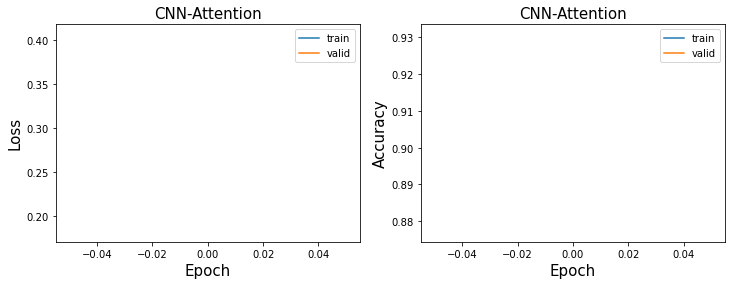

Train loss for epoch 1: 0.3007071018218994
Val loss for epoch 1: 0.1886860728263855
Train loss for epoch 2: 0.2693383991718292
Val loss for epoch 2: 0.18275107443332672
Train loss for epoch 3: 0.25804242491722107
Val loss for epoch 3: 0.19757334887981415
Train loss for epoch 4: 0.2412641942501068
Val loss for epoch 4: 0.22759325802326202
Train loss for epoch 5: 0.23470439016819
Val loss for epoch 5: 0.211757630109787
Train loss for epoch 6: 0.2358974814414978
Val loss for epoch 6: 0.2258124202489853
Train loss for epoch 7: 0.22430023550987244
Val loss for epoch 7: 0.2315828949213028
Train loss for epoch 8: 0.24649281799793243
Val loss for epoch 8: 0.2181456834077835
Train loss for epoch 9: 0.22014065086841583
Val loss for epoch 9: 0.21840524673461914
Train loss for epoch 10: 0.2184436023235321
Val loss for epoch 10: 0.23129083216190338


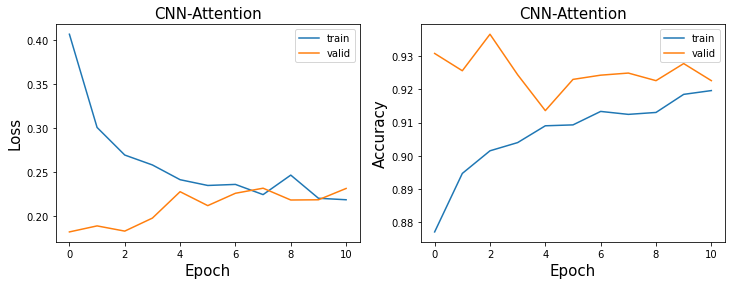

Train loss for epoch 11: 0.21342678368091583
Val loss for epoch 11: 0.21939018368721008
Train loss for epoch 12: 0.20835867524147034
Val loss for epoch 12: 0.22664572298526764
Train loss for epoch 13: 0.20277158915996552
Val loss for epoch 13: 0.2578452527523041
Train loss for epoch 14: 0.20961500704288483
Val loss for epoch 14: 0.233217254281044
Train loss for epoch 15: 0.20676974952220917
Val loss for epoch 15: 0.22664818167686462
Train loss for epoch 16: 0.19871948659420013
Val loss for epoch 16: 0.2280484288930893
Train loss for epoch 17: 0.19685253500938416
Val loss for epoch 17: 0.22650352120399475
Train loss for epoch 18: 0.198194220662117
Val loss for epoch 18: 0.22028788924217224
Train loss for epoch 19: 0.19346651434898376
Val loss for epoch 19: 0.2585158050060272
Train loss for epoch 20: 0.18954770267009735
Val loss for epoch 20: 0.2593318819999695


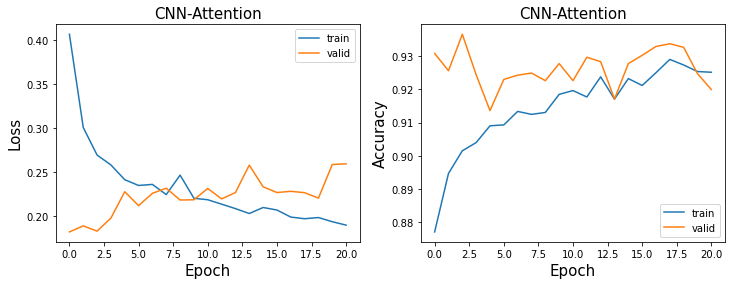

Train loss for epoch 21: 0.19030822813510895
Val loss for epoch 21: 0.24123264849185944
Train loss for epoch 22: 0.1862896829843521
Val loss for epoch 22: 0.24648991227149963
Train loss for epoch 23: 0.1820140779018402
Val loss for epoch 23: 0.24033764004707336
Train loss for epoch 24: 0.18040664494037628
Val loss for epoch 24: 0.23459070920944214
Train loss for epoch 25: 0.1855219304561615
Val loss for epoch 25: 0.26256710290908813
Train loss for epoch 26: 0.19263820350170135
Val loss for epoch 26: 0.24808631837368011
Train loss for epoch 27: 0.18554678559303284
Val loss for epoch 27: 0.2830895483493805
Train loss for epoch 28: 0.18317458033561707
Val loss for epoch 28: 0.2919480800628662
Train loss for epoch 29: 0.1724279820919037
Val loss for epoch 29: 0.2499939501285553
Train loss for epoch 30: 0.17481893301010132
Val loss for epoch 30: 0.28468629717826843


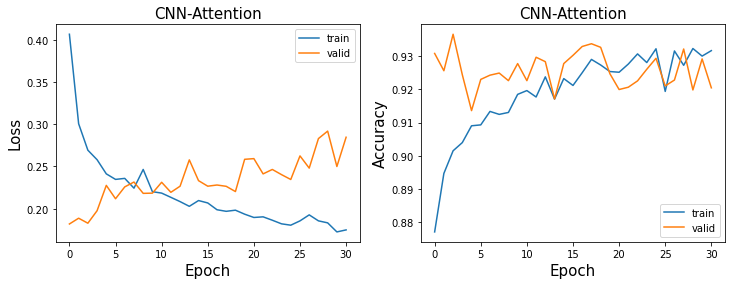

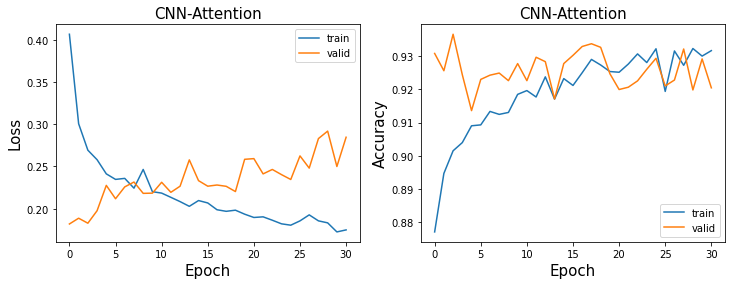

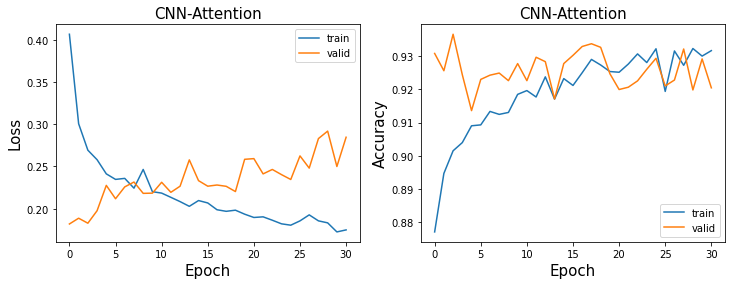

In [37]:
# Attention1 (separate dates, upsample only train, all labels for Attention1)
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, train_loader, T_length=3, device='cuda')
    val_loss, val_acc = evaluate(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, val_loader, T_length=3, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_Att.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
    elif verbose:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    if epoch % 10 == 0:
        plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)
    # if epoch == num_epochs-1:
        # torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

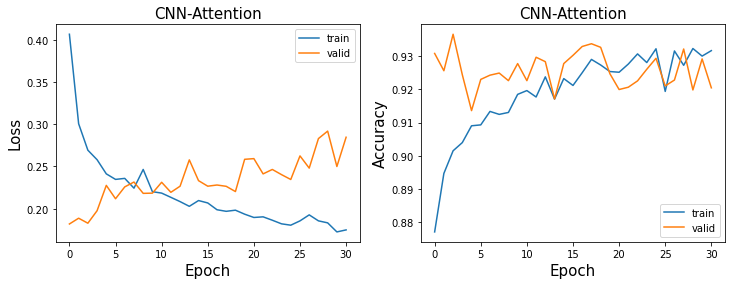

In [41]:
fig = plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)
fig.savefig(load_path + 'figures/Goose_1st/'+'CNN_Attention_short_model_no_pos_enc_no_Q_drop.jpg')

In [ ]:
learning_rate = 0.001
num_epochs = 51
model_type = 'CNN-Attention'
loss_type = 'bce'
p_dropout = 0.2
att_dim = 128
T_length = 3
all_label = False
verbose = True

model_CNN = CNN(p_dropout, att_dim).to(device)
model_Att = Attention1(att_dim, T_length, all_label).to(device)
optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr = learning_rate)
optimizer_Att = torch.optim.Adam(model_Att.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

In [ ]:
# Attention1 (separate dates, upsample only train, mid labels for Attention1)
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, train_loader, T_length=3, device='cuda')
    val_loss, val_acc = evaluate(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, val_loader, T_length=3, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_Att.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
    elif verbose:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
    # if epoch == num_epochs-1:
        # torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [ ]:
learning_rate = 0.001
num_epochs = 51
model_type = 'CNN-Attention'
loss_type = 'bce'
p_dropout = 0.2
att_dim = 128
T_length = 3
all_label = True
verbose = True

model_CNN = CNN(p_dropout, att_dim).to(device)
model_Att = Attention1(att_dim, T_length, all_label).to(device)
optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr = learning_rate)
optimizer_Att = torch.optim.Adam(model_Att.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

In [ ]:
# Attention1 (separate dates, upsample train/val, all labels for Attention1)
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, train_loader, T_length=3, device='cuda')
    val_loss, val_acc = evaluate(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, val_loader, T_length=3, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_Att.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
    elif verbose:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
    # if epoch == num_epochs-1:
        # torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [ ]:
learning_rate = 0.001
num_epochs = 51
model_type = 'CNN-Attention'
loss_type = 'bce'
p_dropout = 0.2
att_dim = 128
T_length = 3
all_label = True
verbose = True

model_CNN = CNN(p_dropout, att_dim).to(device)
model_Att = Attention1(att_dim, T_length, all_label).to(device)
optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr = learning_rate)
optimizer_Att = torch.optim.Adam(model_Att.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

In [ ]:
# Attention1 (separate dates, upsample train/val, all labels for Attention1, not shuffle val/test)
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, train_loader, T_length=3, device='cuda')
    val_loss, val_acc = evaluate(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, val_loader, T_length=3, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_Att.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
    elif verbose:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
    # if epoch == num_epochs-1:
        # torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

#### Analysis

In [ ]:
val_labels = []
for a,b,c,d,e in val_loader:
    val_labels.extend(b.numpy().flatten())  

In [ ]:
np.mean(np.array(val_labels))

In [ ]:
model_CNN.eval()
model_Att.eval()
epoch_losses = 0
val_preds, val_labels = [], []    
with torch.no_grad():
    for batch_idx, (data, labels, _, _, _) in enumerate(val_loader):
        labels = labels.to(device).float()
        CNN_outputs = torch.zeros(data[0].shape[0], len(data), att_dim, device=device)
        for t in range(T_length):
            data_t = data[t].to(device).float()
            CNN_outputs[:, t, :] = model_CNN(data_t)
        pos = torch.LongTensor([list(range(T_length))]).to(device)
        Att_outputs = model_Att(CNN_outputs, pos)
        val_preds.extend(Att_outputs.detach().cpu().numpy().flatten())
        val_labels.extend(labels.detach().cpu().numpy().flatten())

In [ ]:
a = (np.array(val_preds) > 0.5) * 1.0
b = np.array(val_labels)

In [ ]:
# Val
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(range(len(b)), b, s=0.5)
plt.title('Labels')
plt.subplot(1,2,2)
plt.scatter(range(len(a)), a, s=0.5)
plt.title('Predictions')
plt.show()